<a href="https://colab.research.google.com/github/AnIsAsPe/Recomendaci-n-de-libros-usando-LDA/blob/main/Notebooks/Recomendaci%C3%B3n_de_libros_usando_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2> Problema:

Se quiere construir un sistema de recomendación de libros basado en los resumentes de los libros y los temas (topicos) de los mismos.

Para tal fin, se utiliza el [CMU Book Summary Dataset](https://www.cs.cmu.edu/~dbamman/booksummaries.html)

# Bibliotecas y funciones

In [5]:
!pip install --upgrade numpy==1.26.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 55.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have

In [1]:
!pip install pyLDAvis  #biblioteca que extrae información de un modelo LDA para obtener una visualización interactiva

In [2]:
# Para leer los datos
import csv
import json

import pandas as pd
import numpy as np
from collections import Counter # para contar frecuencias

# preprocesar texto
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Modelado de tópicos
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # al instalar pyLDAvis ocasiona un warning con ipkernel

In [3]:
import sklearn

for lib in [sklearn, pyLDAvis, np, pd]:
  print(lib.__name__, lib.__version__)

sklearn 1.6.1
pyLDAvis 3.4.0
numpy 1.26.4
pandas 2.2.2


In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Lectura y exploración de datos

In [39]:
!curl -o "/content/booksummaries.tar.gz" "https://raw.githubusercontent.com/AnIsAsPe/Recomendaci-n-de-libros-usando-LDA/refs/heads/main/Datos/booksummaries.tar.gz"
!tar -xzvf "/content/booksummaries.tar.gz" -C"/content/"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.0M  100 16.0M    0     0   9.9M      0  0:00:01  0:00:01 --:--:--  9.9M
booksummaries/
booksummaries/README
booksummaries/booksummaries.txt


In [40]:
data = []

with open("/content/booksummaries/booksummaries.txt", 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in reader:
        data.append(row)

In [6]:
len(data)

16559

In [8]:
data[3]

['1756',
 '/m/0sww',
 'An Enquiry Concerning Human Understanding',
 'David Hume',
 '',
 '',
 ' The argument of the Enquiry proceeds by a series of incremental steps, separated into chapters which logically succeed one another. After expounding his epistemology, Hume explains how to apply his principles to specific topics. In the first section of the Enquiry, Hume provides a rough introduction to philosophy as a whole. For Hume, philosophy can be split into two general parts: natural philosophy and the philosophy of human nature (or, as he calls it, "moral philosophy"). The latter investigates both actions and thoughts. He emphasizes in this section, by way of warning, that philosophers with nuanced thoughts will likely be cast aside in favor of those whose conclusions more intuitively match popular opinion. However, he insists, precision helps art and craft of all kinds, including the craft of philosophy. Next, Hume discusses the distinction between impressions and ideas. By "impressio

In [9]:
title = []
author = []
summary = []
for i in range(len(data)):
  title.append(data[i][2])
  author.append(data[i][3])
  summary.append(data[i][6])

datos = pd.DataFrame({ 'Title': title, 'Author': author,
                    'Summary': summary})
print(datos.shape)
datos.head(3)


(16559, 3)


,Title,Author,Summary
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,The text of The Plague is divided into five p...


In [10]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Title    16559 non-null  object
 1   Author   16559 non-null  object
 2   Summary  16559 non-null  object
dtypes: object(3)
memory usage: 388.2+ KB


In [ ]:
datos[['Title', 'Author']].nunique()


,0
Title,16277
Author,4715


In [11]:
datos.Title.value_counts().head()

,count
Title,
Nemesis,6
Outcast,4
Haunted,4
Inferno,4
The Gift,3


 ¿por qué hay más de un resumen para cada titulo?

In [12]:
datos[datos.Title=='Nemesis']

,Title,Author,Summary
375,Nemesis,Isaac Asimov,The novel is set in an era in which interstel...
3499,Nemesis,Agatha Christie,Miss Marple receives a post card from the rec...
5157,Nemesis,Scott Ciencin,One of Fred's old friends from graduate schoo...
6159,Nemesis,Jo Nesbø,A bank robbery is committed by a lone robber ...
13696,Nemesis,Philip Roth,Nemesis explores the effect of a 1944 polio e...
13842,Nemesis,,"The story, set in Latium in AD 77, opens with..."


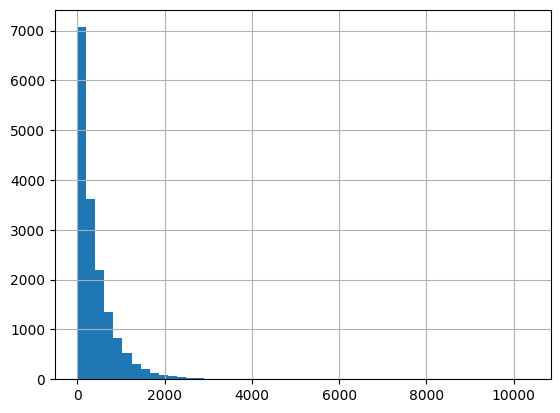

In [13]:
datos['len Summary'] = datos['Summary'].apply(lambda x: len(str(x).split()))
datos['len Summary'].hist(bins=50)
plt.show()

In [15]:

datos['len Summary'].describe(percentiles=[0.025, 0.05,0.10, 0.25,0.50, 0.75,0.90, 0.95, 0.975])

,len Summary
count,16559.000000
mean,429.202126
std,500.339692
min,1.000000
2.5%,29.000000
5%,44.000000
10%,64.000000
25%,120.000000
50%,263.000000
75%,569.000000


In [14]:
# Incluiremos en el dataset solamente resumentes con más de 30 palabras y menos de 1313 (sacrificando 7.5% de los datos)
quantile_025 = datos['len Summary'].quantile(0.025)
quantile_095 = datos['len Summary'].quantile(0.95)
filtro = (datos['len Summary'] > quantile_025) & (datos['len Summary'] < quantile_095)
df = datos[filtro].copy().reset_index(drop=True)
df.shape

(15297, 4)

# Obtener los tópicos principales

## Vectorización de textos

In [18]:
st = PorterStemmer()
stop_words = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

def preprocesar(texto):
      # Convierte a minúsculas
      texto = (texto).lower()

      # Elimina stopwords
      texto = stop_words.sub('', texto)
      # Elimina puntuación y números
      texto = re.sub('[^a-z]+', ' ', texto)

      # Normalización y eliminación palabras que tengan menos de tres caracteres
      texto = texto.split()
      stemmed_words = [st.stem(i) for i in texto if len(i)>2]
      texto = ' '.join(stemmed_words)

      return(texto)

In [19]:
df['Summary_pp'] = df['Summary'].apply(preprocesar)
df.head()

,Title,Author,Summary,len Summary,Summary_pp
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",957,old major old boar manor farm call anim farm m...
1,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",998,alex teenag live near futur england lead gang ...
2,The Plague,Albert Camus,The text of The Plague is divided into five p...,1119,text plagu divid five part town oran thousand ...
3,A Fire Upon the Deep,Vernor Vinge,The novel posits that space around the Milky ...,722,novel posit space around milki way divid conce...
4,All Quiet on the Western Front,Erich Maria Remarque,"The book tells the story of Paul Bäumer, a Ge...",770,book tell stori paul umer german soldier urg s...


In [21]:
vectorizer = CountVectorizer(min_df=10, max_df =0.10,  ngram_range=(1,2))
BOW = vectorizer.fit_transform(df['Summary_pp'])
BOW.shape

(15297, 28929)

In [22]:
vocabulario = vectorizer.get_feature_names_out()
len(vocabulario)

28929

In [23]:
vocabulario[375:400]

array(['afternoon', 'afterward', 'afterword', 'agamemnon', 'agatha',
       'age die', 'age differ', 'age eight', 'age eighteen', 'age father',
       'age fifteen', 'age five', 'age group', 'age man', 'age mother',
       'age old', 'age process', 'age stori', 'age ten', 'age thirteen',
       'age three', 'age twelv', 'age twenti', 'age two', 'age woman'],
      dtype=object)

## Entrenamiento del modelo

El número óptimo de topicos depende de las caracteristicas del texto a analizar (el largo de los textos, la cantidad de distintas ideas)

No obstante existen algunas metricas que ayudan a determinar k.

In [24]:
k = 13

In [25]:

lda_model = LatentDirichletAllocation(n_components=k, learning_method='online',
                                      random_state=42, max_iter=30)

In [26]:
%%time
lda_model.fit(BOW) # entrena el modelo y obtienela matriz documento-topico

CPU times: user 3min 41s, sys: 181 ms, total: 3min 41s
Wall time: 3min 44s


LatentDirichletAllocation(learning_method='online', max_iter=30,
                          n_components=13, random_state=42)

In [27]:
lda_model.perplexity(BOW)

8447.38962185993

### Guardamos modelo

In [ ]:
import pickle
path = '/content/drive/MyDrive/Modelos/modelosLDA/LDA Books/'
tuple_models = (lda_model, BOW, vectorizer)
pickle.dump(tuple_models, open (path + "tuple_model_books_k13.pkl", 'wb'))

In [ ]:
import pickle
path = '/content/drive/MyDrive/Modelos/modelosLDA/LDA Books/'
lda_model, BOW, vectorizer = pickle.load(open(path + "tuple_model_books_k13.pkl", 'rb'))


### Distribución de temas en cada resumen  ($β$)  n x k

In [28]:
doc_top = pd.DataFrame(lda_model.transform(BOW))
print(doc_top.shape)
doc_top.head()

(15297, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.091498,0.351531,0.047480,0.158151,0.052424,0.112812,0.000174,0.092196,0.093037,0.000174,0.000174,0.000174,0.000174
1,0.762454,0.028496,0.015276,0.000160,0.033352,0.000160,0.082281,0.000160,0.077024,0.000160,0.000160,0.000160,0.000160
2,0.241366,0.000171,0.171305,0.000171,0.000171,0.000171,0.043972,0.222397,0.113147,0.000171,0.000171,0.206619,0.000171
3,0.074360,0.000231,0.000231,0.132744,0.000231,0.000231,0.000231,0.000231,0.182837,0.322722,0.000231,0.285489,0.000231
4,0.289415,0.132384,0.111580,0.000275,0.216581,0.181595,0.000275,0.000275,0.042130,0.024666,0.000275,0.000275,0.000275


In [ ]:
doc_top.sum(axis=1)

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
15292,1.0
15293,1.0
15294,1.0
15295,1.0


In [37]:
df_lda = pd.merge(df, doc_top, left_index=True, right_index=True)
df_lda.head(2)

,Title,Author,Summary,len Summary,Summary_pp,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Animal Farm,George Orwell,"Old Major, the old boar on the Manor Farm, ca...",957,old major old boar manor farm call anim farm m...,0.091498,0.351531,0.047480,0.158151,0.052424,0.112812,0.000174,0.092196,0.093037,0.000174,0.000174,0.000174,0.000174
1,A Clockwork Orange,Anthony Burgess,"Alex, a teenager living in near-future Englan...",998,alex teenag live near futur england lead gang ...,0.762454,0.028496,0.015276,0.000160,0.033352,0.000160,0.082281,0.000160,0.077024,0.000160,0.000160,0.000160,0.000160


### Distribución de palabras en cada tema ($\theta$) k x d

In [30]:
word_distribution_topic = lda_model.components_ /lda_model.components_.sum(axis=1)[:, np.newaxis]
θs = pd.DataFrame(word_distribution_topic,
                         columns=vocabulario)
print(θs.shape)
θs

(13, 28929)


,aaron,aback,abandon,abandon citi,abandon famili,abandon home,abandon hous,abandon plan,abandon quest,abandon ship,...,zodiac,zoe,zoey,zola,zombi,zone,zoo,zuckerman,zulu,zurich
0,2.384868e-07,3.171599e-05,0.000587,2.384857e-07,2.384907e-07,3.178411e-05,2.384874e-07,2.384989e-07,2.384907e-07,2.384845e-07,...,2.384864e-07,2.384851e-07,2.384868e-07,2.384875e-07,2.384862e-07,2.889666e-05,2.384871e-07,2.384846e-07,2.384907e-07,2.384857e-07
1,1.000755e-03,6.521548e-07,0.000011,6.521502e-07,6.521530e-07,6.521559e-07,6.521634e-07,6.521529e-07,6.521548e-07,6.521510e-07,...,6.521564e-07,6.521614e-07,6.521582e-07,6.521500e-07,6.521597e-07,6.521574e-07,4.295375e-04,6.521554e-07,6.521519e-07,6.521586e-07
2,3.500941e-07,3.500926e-07,0.000098,3.500919e-07,3.500998e-07,3.501069e-07,3.500906e-07,3.501015e-07,3.500985e-07,3.500909e-07,...,3.500962e-07,3.500907e-07,3.500897e-07,3.500952e-07,3.500949e-07,3.500934e-07,3.500942e-07,1.548509e-04,3.500928e-07,3.500931e-07
3,1.130344e-06,1.130349e-06,0.000610,1.130374e-06,1.130400e-06,1.130348e-06,1.130367e-06,1.130473e-06,1.130343e-06,1.130345e-06,...,1.130343e-06,1.130348e-06,1.130344e-06,1.130350e-06,1.130367e-06,1.773577e-03,6.236300e-04,1.130342e-06,1.130339e-06,1.130342e-06
4,2.492606e-07,3.042132e-05,0.000800,2.492574e-07,6.594408e-05,2.492658e-07,6.112901e-05,1.177281e-05,2.492596e-07,2.492576e-07,...,2.492600e-07,3.843000e-04,2.492600e-07,2.492612e-07,2.492597e-07,2.492597e-07,8.326272e-05,2.492595e-07,2.492648e-07,7.160635e-05
5,6.588173e-07,6.588162e-07,0.000356,6.588144e-07,6.588203e-07,6.588275e-07,6.588157e-07,6.588312e-07,6.588987e-07,6.588145e-07,...,6.588110e-07,6.588118e-07,1.802070e-03,2.735675e-04,6.588148e-07,6.588162e-07,6.588197e-07,6.588139e-07,1.417332e-04,6.588367e-07
6,4.393032e-07,4.392976e-07,0.000069,4.392969e-07,4.392987e-07,4.393223e-07,4.393028e-07,4.393046e-07,4.392991e-07,4.392966e-07,...,4.393100e-07,4.393031e-07,4.392963e-07,4.392990e-07,4.393021e-07,4.393002e-07,4.393057e-07,4.392982e-07,4.393312e-07,4.393407e-07
7,2.171100e-05,5.662034e-07,0.000992,5.661934e-07,5.662016e-07,5.662055e-07,5.661995e-07,7.506804e-05,5.662219e-07,5.661935e-07,...,5.661955e-07,5.661964e-07,5.661975e-07,5.661998e-07,5.661964e-07,5.661979e-07,5.661981e-07,5.661953e-07,5.662074e-07,5.662094e-07
8,4.110902e-07,4.110872e-07,0.000290,4.110902e-07,4.110923e-07,4.110879e-07,4.110869e-07,4.111588e-07,4.111039e-07,4.110836e-07,...,6.933409e-05,4.110879e-07,4.110832e-07,4.110858e-07,4.110933e-07,4.212605e-04,4.110882e-07,4.110864e-07,4.110896e-07,4.110977e-07
9,5.383727e-07,5.383655e-07,0.000888,5.383733e-07,5.383716e-07,5.383706e-07,5.383714e-07,5.384278e-07,5.383646e-07,1.319592e-04,...,5.484160e-05,5.383785e-07,5.383682e-07,5.383639e-07,5.383752e-07,5.383786e-07,5.484394e-07,5.383641e-07,5.383650e-07,5.383781e-07


In [ ]:
θs.sum(axis=1)

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


In [31]:
for top in range(k):
  print('\nPalabras más frecuentes del topico {}'.format(top))
  tokMasFrec = θs.T.loc[:,top].sort_values(ascending=False).head(10).index
  for tok in tokMasFrec:
      print(tok)


Palabras más frecuentes del topico 0
arthur
student
women
game
cannot
mean
beauti
accept
mind
question

Palabras más frecuentes del topico 1
vampir
sam
peter
ben
jack
michael
dog
parent
angel
billi

Palabras más frecuentes del topico 2
chapter
narrat
describ
author
write
fiction
god
main
histori
reader

Palabras más frecuentes del topico 3
david
univers
futur
jake
rachel
creat
machin
earth
control
comput

Palabras más frecuentes del topico 4
money
job
york
new york
tom
parent
hospit
go
paul
car

Palabras más frecuentes del topico 5
john
british
german
french
harri
england
soldier
armi
london
franc

Palabras más frecuentes del topico 6
polic
miss
case
mr
suspect
crime
offic
sir
killer
detect

Palabras más frecuentes del topico 7
marriag
husband
mari
henri
ladi
richard
ann
wed
lover
fall love

Palabras más frecuentes del topico 8
unit
govern
american
polit
unit state
presid
gener
militari
nation
agent

Palabras más frecuentes del topico 9
ship
earth
planet
crew
space
alien
captain
race


### Visualización del modelo

In [ ]:
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

prepared_data = pyLDAvis.lda_model.prepare(lda_model, BOW, vectorizer)
display(prepared_data)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.020842  0.127435       1        1  14.713557
4     -0.172931  0.137005       2        1  13.766878
11    -0.054799 -0.021095       3        1  12.893125
2      0.161265  0.146696       4        1   9.946231
8      0.181960 -0.038020       5        1   8.465105
6     -0.102346  0.020196       6        1   7.893672
9      0.130936 -0.020057       7        1   6.559441
7     -0.146624  0.003251       8        1   6.179526
5     -0.021909 -0.153867       9        1   5.278184
1     -0.243691  0.120759      10        1   5.246081
12    -0.012452 -0.307833      11        1   3.434907
3      0.241340  0.138164      12        1   3.070381
10     0.018409 -0.152635      13        1   2.552912, topic_info=          Term         Freq        Total Category  logprob  loglift
13702     king  3361.000000  3361.000000  Default  30.0000  30.0000
23016     ship  3778.000000  3778.000000  Default  29.0000  29.0000
7281     earth  2842.000000  2842.000000  Default  28.0000  28.0000
19607   planet  2123.000000  2123.000000  Default  27.0000  27.0000
1324      armi  2300.000000  2300.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
26443     true   213.822410  1424.584330  Topic13  -5.5837   1.7714
16489     mind   200.483712  1546.537623  Topic13  -5.6481   1.6249
28        abil   192.682638  1046.019657  Topic13  -5.6878   1.9762
16255   memori   194.492557  1269.687661  Topic13  -5.6785   1.7918
20325  protect   182.955132  1352.307502  Topic13  -5.7396   1.6676

[896 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
22         8  0.994383     abel
28         1  0.243781     abil
28         3  0.257165     abil
28         4  0.027724     abil
28         5  0.086040     abil
...      ...       ...      ...
28817      6  0.005458     york
28817      9  0.032064     york
28901     11  0.986840  yuuzhan
28921      9  0.995840     zoey
28923      3  0.994962    zombi

[2654 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 12, 3, 9, 7, 10, 8, 6, 2, 13, 4, 11])

## Sistema de recomendación usando similitud coseno


<p align="center">
  <img src="https://drive.google.com/uc?export=view&id=1t6gQrFy1UMe_GtuGNDND90MqcebTeJD_" width="45%">
</p>

.

$$\text{similitud coseno}(A, B) = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} ~~~\sqrt{\sum_{i=1}^{n} B_i^2}}$$

In [32]:

def similitud_coseno(a_vector, b_vector):
    '''Calcula la similitud coseno entre los vectores a y b'''

    numerador = np.dot(a_vector, b_vector)

    a_norm = np.sqrt(np.sum(a_vector**2))
    b_norm = np.sqrt(np.sum(b_vector**2))

    denominador = a_norm * b_norm

    similitud_coseno = numerador / denominador

    return similitud_coseno

In [34]:
def documentos_similares(titulo):
  inx = df[df['Title']==titulo].index[0]
  q_k = doc_top.loc[inx].values
  n = doc_top.shape[0]
  similaridad = {}
  relevantes={}

  # Calcular similitud coseno
  for doc_inx in range(n):
      if doc_inx == inx:
          continue
      similaridad[doc_inx] = similitud_coseno(q_k, doc_top.loc[doc_inx].values)

  rank = {k:v for k,v in sorted(similaridad.items(), key=lambda x: x[1],
                                reverse=True)}
  top5= pd.DataFrame.from_dict(rank, orient = 'index', columns=['sim_cos']).head()
  recomendaciones = pd.merge(df.iloc[:,0:3], top5, how='right',  right_index=True, left_index=True)
  recomendaciones.index = np.arange(1, 6)

  return recomendaciones



In [35]:
documentos_similares('Dune')

,Title,Author,Summary,sim_cos
1,Children of Dune,Frank Herbert,Nine years after Emperor Paul Muad'dib walked...,0.963696
2,Feet of Clay,Terry Pratchett,A cabal of Ankh-Morpork's guild leaders seeks...,0.930127
3,Men at Arms,Terry Pratchett,"Edward d'Eath, an Assassin and son of a down-...",0.928785
4,Deryni Rising,Katherine Kurtz,The book covers a two-week period in November...,0.923190
5,Sword Stained with Royal Blood,Louis Cha,"Set in the late Ming Dynasty, the story cente...",0.910172


In [ ]:
documentos_similares('The Time Machine')

,Title,Author,Summary,sim_cos
1,Tarzan the Invincible,Edgar Rice Burroughs,"Tarzan, his monkey friend Nkima, and Chief Mu...",0.970436
2,The Tent Dwellers,Albert Bigelow Paine,The book chronicles a three-week fishing trip...,0.968982
3,Beyond the Golden Stair,Hannes Bok,"Hibbert, an imprisoned innocent, is caught up...",0.967470
4,The Algebra of Ice,Lloyd Rose,The Doctor and Ace investigate a 'crop circle...,0.954169
5,Tarzan: the Lost Adventure,Joe R. Lansdale,"In Burroughs' last Tarzan story, left unfinis...",0.940487


In [38]:
df_lda[df_lda.Title =="Children of Dune"]

,Title,Author,Summary,len Summary,Summary_pp,0,1,2,3,4,5,6,7,8,9,10,11,12
20,Children of Dune,Frank Herbert,Nine years after Emperor Paul Muad'dib walked...,622,nine year emperor paul muad dib walk desert bl...,0.139001,0.00535,0.000308,0.000308,0.000308,0.000308,0.000308,0.028174,0.053488,0.024602,0.630708,0.000308,0.11683
